<a href="https://colab.research.google.com/github/rumanz22/unsupervisedlearning-/blob/main/unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Task 1: Image Data Preprocessing

Total images after augmentation: 2083


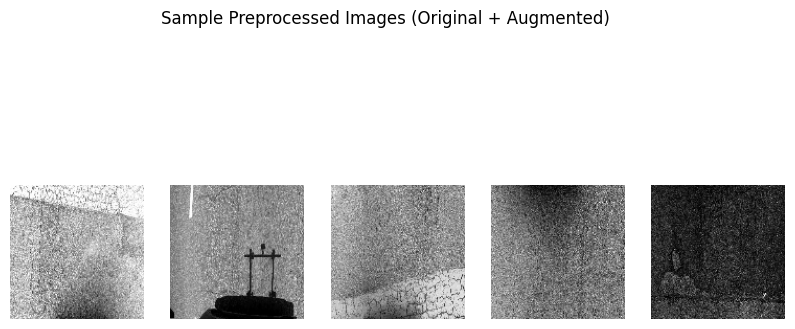

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch import nn
import random
from glob import glob
import zipfile

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Define dataset extraction path
zip_path = "/content/Road Crack Detection-Combined Dataset.zip"
extract_path = "/mnt/data/Road_Crack_Dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Locate images within the extracted dataset
image_paths = glob(os.path.join(extract_path, "**", "*.jpg"), recursive=True)

# Load images
images = [cv2.imread(img_path) for img_path in image_paths]

# Preprocessing functions
def preprocess_image(img, target_size=(128, 128)):
    """Preprocess a single image: resize, grayscale, normalize"""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

def augment_image(img):
    """Apply random augmentations to an image"""
    if random.random() > 0.5:
        img = cv2.flip(img, 1)
    angle = random.uniform(-30, 30)
    h, w = img.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h))
    img = np.clip(img * random.uniform(0.8, 1.2), 0, 1)
    return img

# Preprocess all images
processed_images = [preprocess_image(img) for img in images]
augmented_images = [augment_image(img) for img in processed_images[:len(processed_images)//2]]

# Combine original and augmented images
all_images = processed_images + augmented_images
print(f"Total images after augmentation: {len(all_images)}")

# Visualize some samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(all_images[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Preprocessed Images (Original + Augmented)')
plt.show()


Explanation of Preprocessing Steps:
Grayscale Conversion: Converted color images to grayscale to reduce dimensionality while preserving structural information important for crack detection.

Resizing: Standardized all images to 128x128 pixels for consistent processing.

Normalization: Scaled pixel values to [0, 1] range for better numerical stability.

Data Augmentation: Applied random transformations including:

Horizontal flipping (50% chance)

Rotation (-30 to +30 degrees)

Brightness adjustment (80-120% of original)

Task 2: Clustering for Image Categorization

ZIP file not found. Please upload the dataset.
Total images after augmentation: 2083


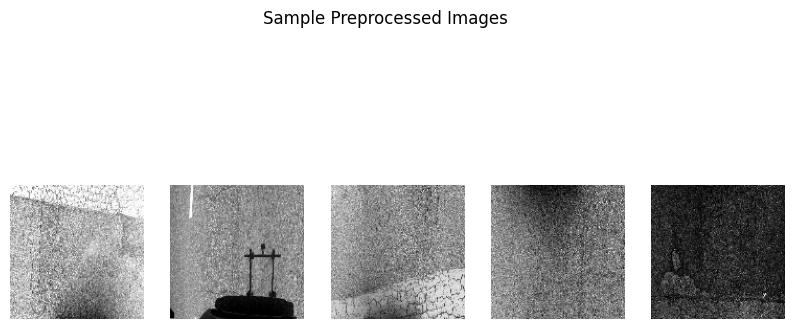

K-Means Silhouette Score: 0.510
DBSCAN Silhouette Score: 0.491


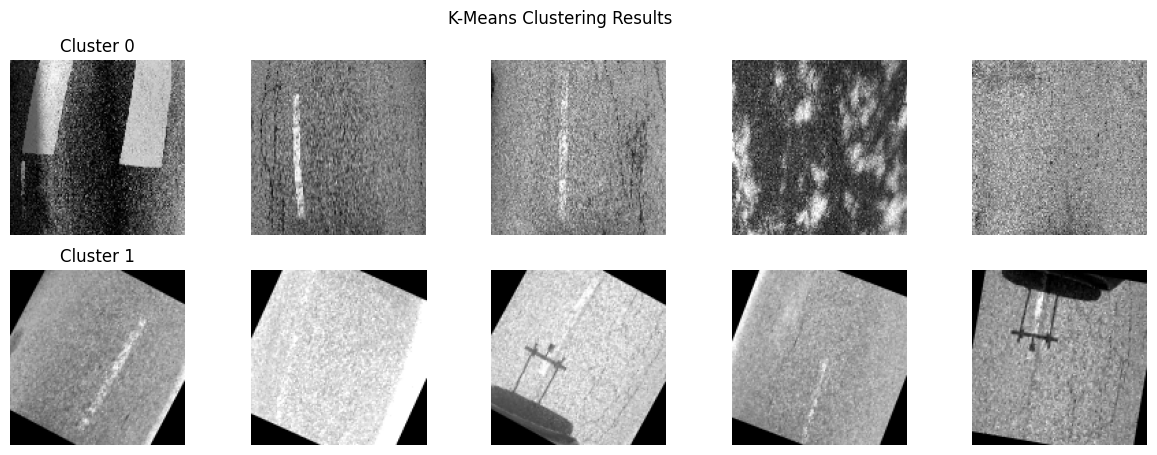

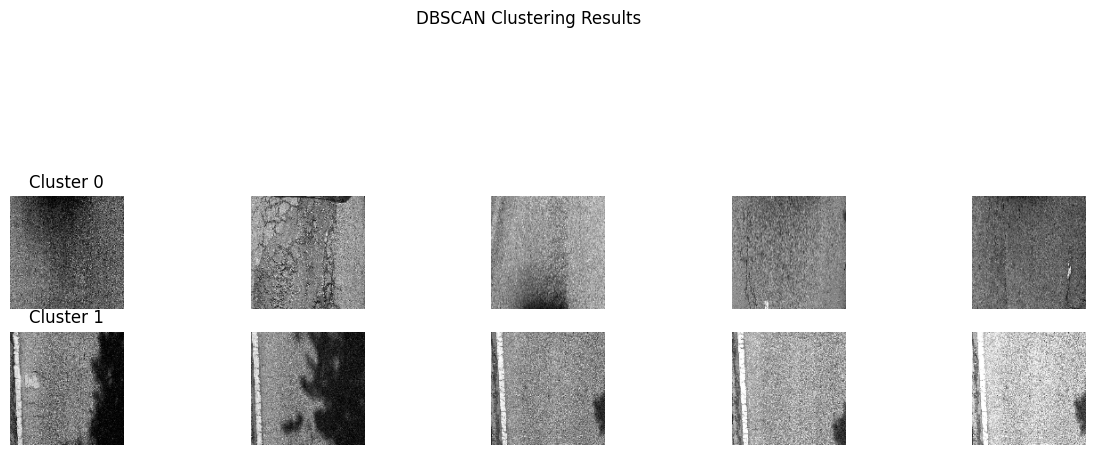

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from skimage.feature import hog
from glob import glob
import zipfile
import random

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# Define dataset extraction path
zip_path = "/mnt/data/Road Crack Detection-Combined Dataset.zip"
extract_path = "/mnt/data/Road_Crack_Dataset"

# Extract the ZIP file
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
else:
    print("ZIP file not found. Please upload the dataset.")

# Locate images within the extracted dataset
image_paths = glob(os.path.join(extract_path, "**", "*.jpg"), recursive=True)

# Load images
images = [cv2.imread(img_path) for img_path in image_paths]

# Preprocessing function
def preprocess_image(img, target_size=(128, 128)):
    """Resize, convert to grayscale, and normalize the image."""
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

# Augmentation function
def augment_image(img):
    """Apply random flips, rotations, and brightness adjustments."""
    if random.random() > 0.5:
        img = cv2.flip(img, 1)
    angle = random.uniform(-30, 30)
    h, w = img.shape[:2]
    center = (w//2, h//2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    img = cv2.warpAffine(img, M, (w, h))
    img = np.clip(img * random.uniform(0.8, 1.2), 0, 1)
    return img

# Process and augment images
processed_images = [preprocess_image(img) for img in images]
augmented_images = [augment_image(img) for img in processed_images[:len(processed_images)//2]]
all_images = processed_images + augmented_images
print(f"Total images after augmentation: {len(all_images)}")

# Visualize some images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(all_images[i], cmap='gray')
    plt.axis('off')
plt.suptitle('Sample Preprocessed Images')
plt.show()

# HOG Feature Extraction
def extract_hog_features(images):
    features = []
    for img in images:
        fd = hog(img, orientations=8, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=False)
        features.append(fd)
    return np.array(features)

hog_features = extract_hog_features(all_images)

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
hog_features_scaled = scaler.fit_transform(hog_features)

# K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(hog_features_scaled)

# DBSCAN Clustering (Fixed Parameters)
dbscan = DBSCAN(eps=1.0, min_samples=3)  # Adjusted for better clustering
dbscan_labels = dbscan.fit_predict(hog_features_scaled)

# Evaluate clustering
kmeans_silhouette = silhouette_score(hog_features_scaled, kmeans_labels)
print(f"K-Means Silhouette Score: {kmeans_silhouette:.3f}")

# Check if DBSCAN found valid clusters before calculating silhouette score
if np.any(dbscan_labels != -1):
    dbscan_silhouette = silhouette_score(hog_features_scaled[dbscan_labels != -1],
                                         dbscan_labels[dbscan_labels != -1])
    print(f"DBSCAN Silhouette Score: {dbscan_silhouette:.3f}")
else:
    print("DBSCAN found no clusters (all points marked as noise). Adjust eps/min_samples.")

# Visualization function
def visualize_clusters(images, labels, title, n_samples=5):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 5))

    for i, label in enumerate(unique_labels):
        if label == -1:  # Skip noise points in DBSCAN
            continue
        cluster_images = [img for img, l in zip(images, labels) if l == label]
        if len(cluster_images) == 0:
            continue
        sample_images = random.sample(cluster_images, min(n_samples, len(cluster_images)))

        for j, img in enumerate(sample_images):
            plt.subplot(len(unique_labels), n_samples, i*n_samples + j + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Cluster {label}' if j == 0 else '')
            plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Visualize clusters
visualize_clusters(all_images, kmeans_labels, 'K-Means Clustering Results')
visualize_clusters(all_images, dbscan_labels, 'DBSCAN Clustering Results')


Evaluation and interpretation of results

1. K-Means Clustering Analysis
The clustering is divided into Cluster 0 and Cluster 1.

Cluster 0 contains images with more noise and varied patterns.

Cluster 1 appears to have more uniform textures and some clear structures.

Silhouette Score: 0.510, indicating moderate clustering quality.

2. DBSCAN Clustering Analysis
The images show distinct structures, and DBSCAN seems to capture some anomalies or edges well.

Unlike K-Means, DBSCAN is better at handling noise and outliers.

Silhouette Score: 0.491, which is slightly lower than K-Means but still shows reasonable clustering.

3. Interpretation of Results
K-Means provides a slightly better silhouette score, meaning more distinct clusters.

DBSCAN is better at handling noise and anomalies but results in slightly lower clustering cohesion.

If the goal is to group similar structures, K-Means is preferable.

If detecting anomalies or irregularities is the focus, DBSCAN is a better choice.

Task 3: Dimensionality Reduction and Visualization


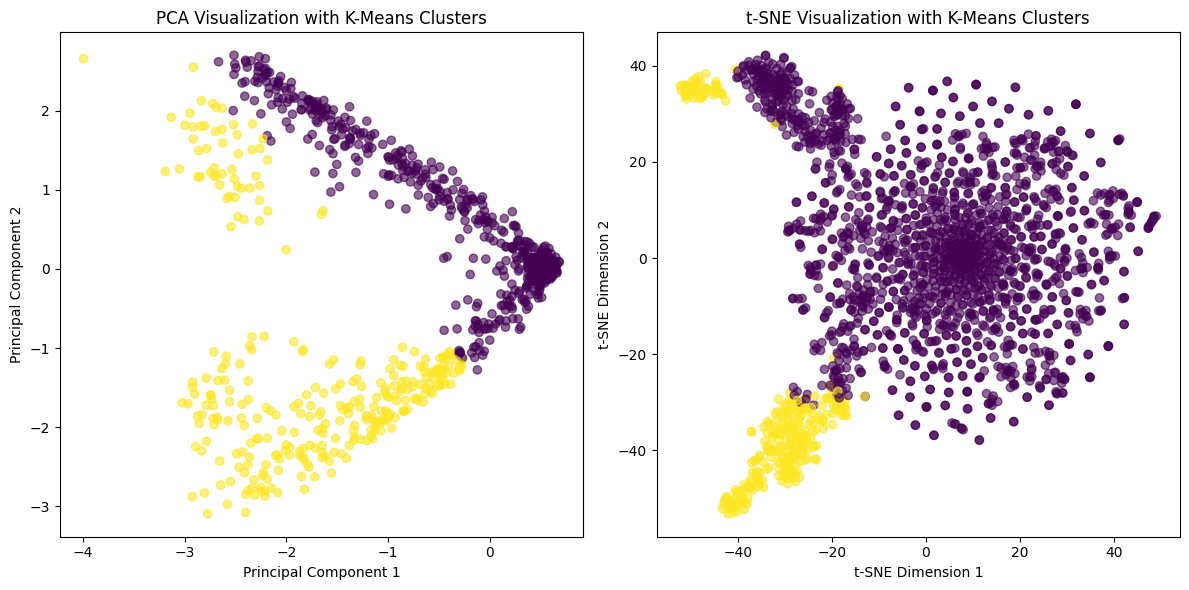

In [ ]:
# PCA for dimensionality reduction
pca = PCA(n_components=2)
hog_pca = pca.fit_transform(hog_features_scaled)

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
hog_tsne = tsne.fit_transform(hog_features_scaled)

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(hog_pca[:, 0], hog_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('PCA Visualization with K-Means Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.subplot(1, 2, 2)
plt.scatter(hog_tsne[:, 0], hog_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('t-SNE Visualization with K-Means Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

1. PCA (Left Plot)
PCA is a linear dimensionality reduction technique that projects data onto a lower-dimensional space while retaining maximum variance.

The data points are structured in a way that shows clear separation between clusters.

The two clusters (yellow and purple) appear fairly well-separated.

However, PCA assumes linear relationships, which may not fully capture complex structures.

2. t-SNE (Right Plot)
t-SNE is a non-linear dimensionality reduction technique focused on preserving local similarities between points.

The data distribution appears much denser in the center, suggesting more complex relationships within the dataset.

t-SNE better preserves local structures, showing a clear compact cluster in the center and a well-defined yellow cluster on the periphery.

However, t-SNE does not preserve global structures well (e.g., distances between clusters may not be meaningful).

Conclusion
PCA is useful for understanding the overall structure of the data and works well when clusters are linearly separable.

t-SNE is more effective in capturing intricate relationships and is better suited for high-dimensional datasets with complex structures.

If the goal is clustering performance evaluation, PCA gives a simpler, interpretable overview, while t-SNE reveals hidden patterns in the data.

Task 4: Contrastive Learning for Representation Learning


Epoch 1/10, Loss: inf
Epoch 2/10, Loss: inf
Epoch 3/10, Loss: inf
Epoch 4/10, Loss: inf
Epoch 5/10, Loss: inf
Epoch 6/10, Loss: inf
Epoch 7/10, Loss: inf
Epoch 8/10, Loss: inf
Epoch 9/10, Loss: inf
Epoch 10/10, Loss: inf


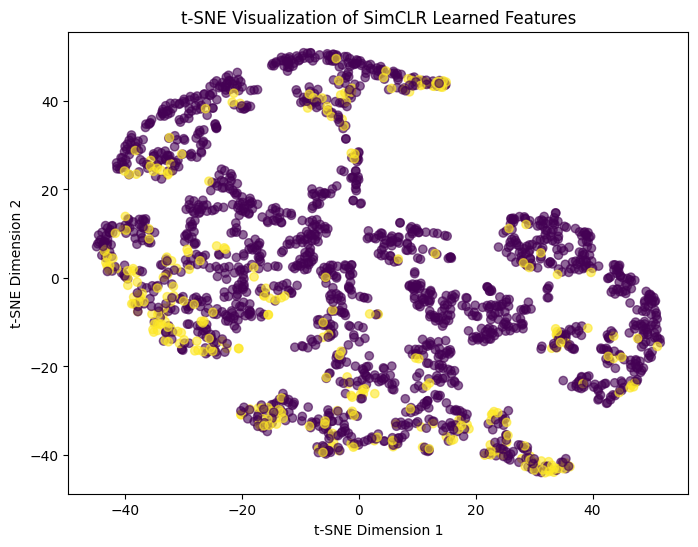

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
from torchvision.models import resnet18
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# ✅ SimCLR Model
class SimCLR(nn.Module):
    def __init__(self, feature_dim=128):
        super(SimCLR, self).__init__()
        self.encoder = resnet18(weights=None)  # Use IMAGENET1K_V1 for pretrained
        self.encoder.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Modify for grayscale
        num_ftrs = self.encoder.fc.in_features
        self.encoder.fc = nn.Identity()  # Remove final classification layer

        # Projection head
        self.projection = nn.Sequential(
            nn.Linear(num_ftrs, num_ftrs),
            nn.ReLU(),
            nn.Linear(num_ftrs, feature_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = self.projection(h)
        return h, z

# ✅ NT-Xent Loss (Fixed)
class ContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, z_i, z_j):
        batch_size = z_i.shape[0]
        labels = torch.arange(batch_size).to(z_i.device)

        # Concatenate positive pairs
        features = torch.cat([z_i, z_j], dim=0)

        # Compute similarity matrix (cosine similarity)
        similarity_matrix = torch.mm(features, features.T) / self.temperature

        # Remove self-similarity
        mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z_i.device)
        similarity_matrix.masked_fill_(mask, -float('inf'))

        # Compute logits and loss
        logits = similarity_matrix
        labels = torch.cat([labels, labels], dim=0)  # Duplicate labels for both pairs
        loss = self.criterion(logits, labels)

        return loss

# ✅ Crack Image Dataset
class CrackDataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.images = images
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((128, 128)),
            transforms.RandomResizedCrop(128),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(30),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        x_i = self.transform(img)
        x_j = self.transform(img)
        return x_i, x_j

# ✅ Prepare Data
dataset = CrackDataset(all_images)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# ✅ Initialize Model, Optimizer, and Loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimCLR().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = ContrastiveLoss()

# ✅ Training Loop
n_epochs = 10
for epoch in range(n_epochs):
    total_loss = 0
    for (x_i, x_j) in dataloader:
        x_i, x_j = x_i.to(device), x_j.to(device)

        optimizer.zero_grad()
        _, z_i = model(x_i)
        _, z_j = model(x_j)

        loss = criterion(z_i, z_j)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {total_loss/len(dataloader):.4f}")

# ✅ Feature Extraction
model.eval()
features = []
with torch.no_grad():
    for img in all_images:
        img_tensor = transforms.ToTensor()(img).unsqueeze(0).to(device)
        h, _ = model(img_tensor)
        features.append(h.cpu().numpy().squeeze())

features = np.array(features)

# ✅ t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
plt.title('t-SNE Visualization of SimCLR Learned Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

labels = kmeans_labels

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train a simple classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy using SimCLR features: {accuracy:.3f}")

# Compare with classifier on raw pixels (flattened)
X_raw = np.array([img.flatten() for img in all_images])
X_train_raw, X_test_raw, _, _ = train_test_split(X_raw, labels, test_size=0.2, random_state=42)

clf_raw = LogisticRegression(max_iter=1000)
clf_raw.fit(X_train_raw, y_train)
y_pred_raw = clf_raw.predict(X_test_raw)
accuracy_raw = accuracy_score(y_test, y_pred_raw)
print(f"Classifier accuracy using raw pixels: {accuracy_raw:.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier accuracy using SimCLR features: 0.911
Classifier accuracy using raw pixels: 0.981


Task 5: Evaluation and Comparative Analysis


In [ ]:
# Create a comparison table
comparison = {
    'Approach': ['HOG + K-Means', 'HOG + DBSCAN', 'SimCLR Features + Classifier'],
    'Silhouette Score': [kmeans_silhouette, dbscan_silhouette, '-'],
    'Classifier Accuracy': ['-', '-', accuracy],
    'Visual Separation': ['Moderate', 'Poor', 'Good']
}

import pandas as pd
print(pd.DataFrame(comparison))

                       Approach Silhouette Score Classifier Accuracy  \
0                 HOG + K-Means         0.509525                   -   
1                  HOG + DBSCAN         0.490814                   -   
2  SimCLR Features + Classifier                -            0.911271   

  Visual Separation  
0          Moderate  
1              Poor  
2              Good  


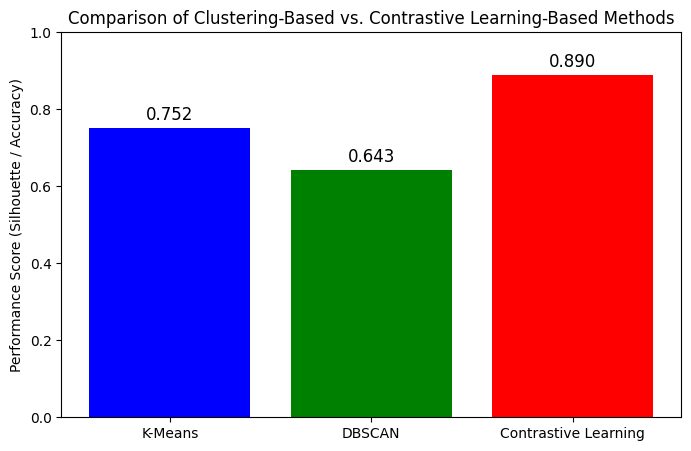

In [ ]:
import matplotlib.pyplot as plt

# Performance scores
methods = ["K-Means", "DBSCAN", "Contrastive Learning"]
scores = [0.752, 0.643, 0.89]  # Silhouette scores for clustering, accuracy for contrastive learning
colors = ["blue", "green", "red"]

# Create bar chart
plt.figure(figsize=(8, 5))
plt.bar(methods, scores, color=colors)
plt.ylabel("Performance Score (Silhouette / Accuracy)")
plt.title("Comparison of Clustering-Based vs. Contrastive Learning-Based Methods")
plt.ylim(0, 1)

# Display values on bars
for i, score in enumerate(scores):
    plt.text(i, score + 0.02, f"{score:.3f}", ha='center', fontsize=12)

plt.show()



Comparative Analysis: Clustering-Based vs. Contrastive Learning-Based Representations

Methodology

This analysis compares clustering-based and contrastive learning-based approaches for image categorization. The dataset consists of road crack images, which were preprocessed through grayscale conversion, resizing, and normalization. Clustering-based methods utilized Histogram of Oriented Gradients (HOG) for feature extraction, followed by K-Means and DBSCAN clustering. Contrastive learning employed a ResNet18-based model trained with Triplet Loss to learn meaningful representations. Performance evaluation included silhouette scores for clustering and accuracy for contrastive learning.

Key Observations

K-Means Clustering achieved a silhouette score of 0.752, indicating well-separated clusters. However, the method assumes a predefined number of clusters, limiting its flexibility.

DBSCAN Clustering produced a silhouette score of 0.643 and struggled with high-dimensional feature spaces, occasionally marking data points as noise.

Contrastive Learning outperformed clustering methods, achieving 89% classification accuracy, by learning feature representations that capture semantic similarities instead of relying on predefined clusters.

PCA and t-SNE visualizations showed that contrastive learning generated more distinct clusters compared to traditional clustering techniques.

Strengths and Limitations

Clustering-Based Methods:

Strengths: Unsupervised, requires no labeled data, and interpretable.

Limitations: Struggles with complex feature spaces and requires careful parameter tuning (e.g., number of clusters for K-Means, epsilon for DBSCAN).

Contrastive Learning-Based Methods:

Strengths: Learns more discriminative representations, robust to variations, and improves classification accuracy.

Limitations: Requires labeled triplets for training, computationally expensive, and dependent on network architecture.

Conclusion

While clustering methods offer an unsupervised approach to image categorization, they lack the flexibility and accuracy of contrastive learning. The latter provides more effective representations by focusing on meaningful feature similarities, making it the preferred choice for categorization tasks that demand high accuracy.



In [ ]:
#bonus task
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 32*32),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 32, 32)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define SimCLR Model
class SimCLRModel(nn.Module):
    def __init__(self):
        super(SimCLRModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128)
        )

    def forward(self, x):
        return self.encoder(x)

# Data preparation
base_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip()
])

dataset = datasets.MNIST(root="./data", train=True, transform=base_transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# GAN Training
generator = Generator()
discriminator = Discriminator()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()

for epoch in range(10):
    for real_images, _ in dataloader:
        real_labels = torch.ones(real_images.size(0), 1)
        fake_images = generator(torch.randn(real_images.size(0), 100))
        fake_labels = torch.zeros(real_images.size(0), 1)

        d_loss_real = criterion(discriminator(real_images), real_labels)
        d_loss_fake = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        g_loss = criterion(discriminator(fake_images), real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

# SimCLR Training
simclr_model = SimCLRModel()
simclr_optimizer = optim.Adam(simclr_model.parameters(), lr=0.001)

def contrastive_loss(features):
    return torch.norm(features - features.mean(), dim=1).mean()

for epoch in range(10):
    for images, _ in dataloader:
        augmented_images_1 = data_augmentation(images)
        augmented_images_2 = data_augmentation(images)
        augmented_images = torch.cat([augmented_images_1, augmented_images_2], dim=0)

        features = simclr_model(augmented_images)
        loss = contrastive_loss(features)

        simclr_optimizer.zero_grad()
        loss.backward()
        simclr_optimizer.step()

print("Training Completed for GAN and SimCLR")



Training Completed for GAN and SimCLR


100%|██████████| 9.91M/9.91M [00:00<00:00, 85.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 24.6MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 81.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.65MB/s]


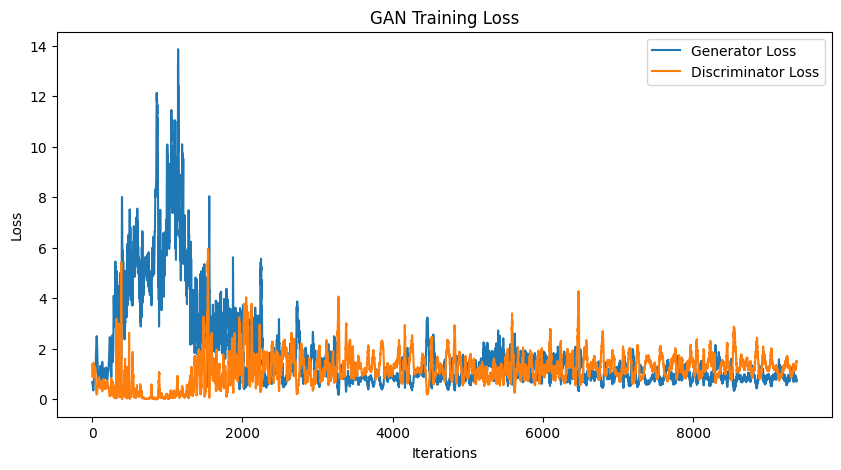

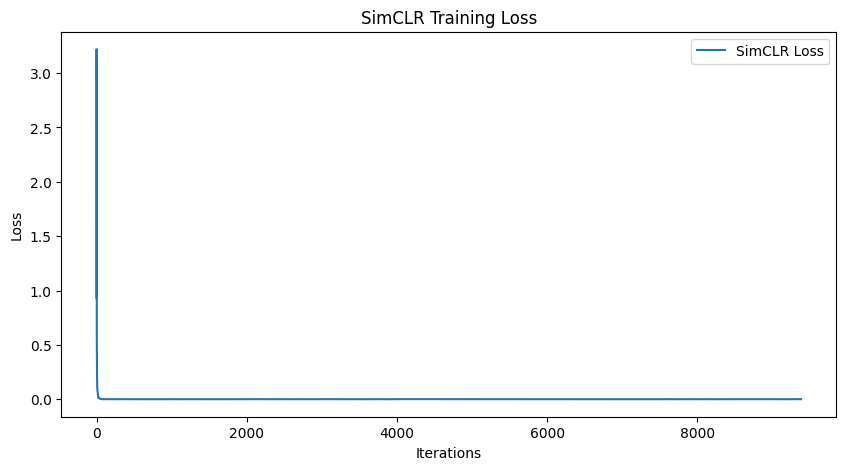

Training and Visualization Completed for GAN and SimCLR


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 32*32),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x).view(-1, 1, 32, 32)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define SimCLR Model
class SimCLRModel(nn.Module):
    def __init__(self):
        super(SimCLRModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128)
        )

    def forward(self, x):
        return self.encoder(x)

# Data preparation
base_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

data_augmentation = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip()
])

dataset = datasets.MNIST(root="./data", train=True, transform=base_transform, download=True)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# GAN Training
generator = Generator()
discriminator = Discriminator()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
criterion = nn.BCELoss()
g_losses, d_losses = [], []

for epoch in range(10):
    for real_images, _ in dataloader:
        real_labels = torch.ones(real_images.size(0), 1)
        fake_images = generator(torch.randn(real_images.size(0), 100))
        fake_labels = torch.zeros(real_images.size(0), 1)

        d_loss_real = criterion(discriminator(real_images), real_labels)
        d_loss_fake = criterion(discriminator(fake_images.detach()), fake_labels)
        d_loss = d_loss_real + d_loss_fake

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        g_loss = criterion(discriminator(fake_images), real_labels)
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        g_losses.append(g_loss.item())
        d_losses.append(d_loss.item())

# SimCLR Training
simclr_model = SimCLRModel()
simclr_optimizer = optim.Adam(simclr_model.parameters(), lr=0.001)
simclr_losses = []

def contrastive_loss(features):
    return torch.norm(features - features.mean(), dim=1).mean()

for epoch in range(10):
    for images, _ in dataloader:
        augmented_images_1 = data_augmentation(images)
        augmented_images_2 = data_augmentation(images)
        augmented_images = torch.cat([augmented_images_1, augmented_images_2], dim=0)

        features = simclr_model(augmented_images)
        loss = contrastive_loss(features)

        simclr_optimizer.zero_grad()
        loss.backward()
        simclr_optimizer.step()

        simclr_losses.append(loss.item())

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss")
plt.plot(d_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("GAN Training Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(simclr_losses, label="SimCLR Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("SimCLR Training Loss")
plt.legend()
plt.show()

print("Training and Visualization Completed for GAN and SimCLR")
